# Land use Classification: Using Arcmap and Python

Object-based image classification (OBIC) is a popular technique for analyzing satellite images, which involves grouping pixels into meaningful objects based on their spatial and spectral properties. OBIC has several advantages over traditional pixel-based classification, such as the ability to capture more complex patterns and to reduce the effects of noise and misclassification. In this article, we will explore the basics of OBIC and its applications in satellite image analysis, with a focus on land use and land cover mapping. We will use the scikit-image and other Python libraries to implement OBIC on real-world satellite imagery data. By the end of the article, readers will have a good understanding of OBIC and its potential for analyzing satellite imagery.

Click [here](https://drive.google.com/drive/folders/1HQk2aMqL2LZbKCnOhDXYEzByiHbHDnXu?usp=sharing) to download the satellite image needed to follow this exercise.

__Output of each steps are provided to follow this exercise from any step. If you just want to skip to object based classification portion click [here](#2).__


# Outline
- [ 1 - Data Preperation](#1)
  - [ 1.1 Dataset](#1.1)
  - [ 1.2 Preparing Training Samples](#1.2)
- [ 2 - Object-Based Image Classification in Python](#2)
  - [ 2.1 Import Libraries and Cleaning Data](#2.1)
  - [ 2.2 Image Segmentation](#2.2)
  - [ 2.3 Get Training Data](#2.3)
  - [ 2.4 Building and Training the Model](#2.4)
  - [ 2.5 Predicting Using the Model](#2.5)
  - [ 2.6 Visualize the Predicted Classes](#2.6)
  - [ 2.7 Save the Prediction as Raster](#2.7)

<a name = "1"></a>
## 1 - Data Preparation

<a name = "1.1"></a>
## 1.1 Dataset

We are using a portion of landsat 5 scene. [Landsat](https://www.usgs.gov/landsat-missions/landsat-5) images can be downloaded from [USGS EarthExplorer](https://earthexplorer.usgs.gov/) website. Then, using any desktop GIS or Remote Sensing software, the bands 1,2,3,4,5 and 7 can be merged into a single raster. Then the resulting raster can be clipped to the study area.

In this exercise, we are going to use the following image. Click [here](https://drive.google.com/drive/folders/1HQk2aMqL2LZbKCnOhDXYEzByiHbHDnXu?usp=sharing) to download.

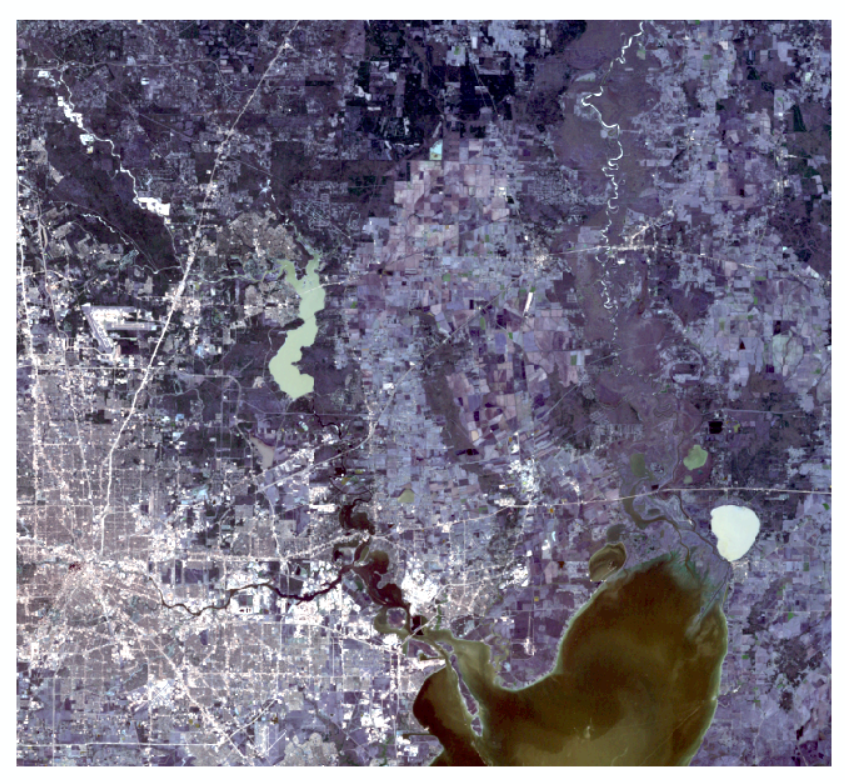

<a name = "1.2"></a>
## 1.2 Preparing Training Samples

To prepare training examples, we have to manually select certain number of pixels and assign them to their respective classes. This can be don in any desktop GIS software.
For this, first we can create point shapefile containing a field called "Classvalue".
Then we can digitize points on the satellite image.

One helpful tip on ArcMap is to first symbolize the points by __Classvalue__ field then pick the corresponding template to add point to the correct class.

<a name="2"></a>
## 2 - Object-Based Image Classification in Python
We will require the following libraries:
- numpy
- matplotlib
- gdal
- skimage
- geopandas
- time

If some libraries are not installed, please remove the hash (#) symbol infront of the corresponding libraries and run the following cell.

In [ ]:
#! pip install numpy
#! pip install geopandas
#! pip install gdal
#! pip install matplotlib
#! pip install -U scikit-image

<a name="2.1"></a>
## 2.1 Import Libraries and Cleaning Data

We will require __gdal__ to read and write raster images.
__gdal__ will convert rasters to __numpy__ arrays they they can be cleaned using __numpy__ library.<br>
We will also need __os__ module for chaning directories.<br>
To use random forest classifier, we will use __sklearn__ module.<br>
We will use __geopandas__ and __ogr__ for reading shapefile.<br>
We will use __matplotlib__ for plotting images.

In [1]:
import os

import numpy as np

from osgeo import gdal
from osgeo import ogr

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier

from skimage import exposure
from skimage.segmentation import quickshift, slic
from skimage.color import label2rgb

import time

In [2]:
# Make sure to change the directory to appropriate folder
os.chdir(r'folder/with/data')

In [3]:
xds = gdal.Open('ldsat2000.img')
X = xds.ReadAsArray()
print(f'Shape of input data is : {X.shape}.')

Shape of input data is : (6, 2499, 2726).


Here we see the band is the first axis, row is the second axis and column is the third axis. We want to move the band to third axis so that our data would be of the shape  _(n_row * n_cols, n_bands)_. Also let's rescale our image to have values between 0 and 1.

In [4]:
Xtab = np.moveaxis(X,0,2)
img = exposure.rescale_intensity(Xtab, out_range = (0, 1))

<a name="2.2"></a>
## 2.2 Image Segmentation

We are going to use [SLIC (Simple Linear Iterative Clustering)](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic)  method of image segmentation from skimage package. It divides an image into superpixels by clustering pixels based on their color similarity and spatial proximity. The algorithm starts with an initial grid of superpixels, and iteratively refines their boundaries to align with the edges in the image. SLIC has several advantages over other segmentation algorithms, such as low computational cost, high accuracy, and the ability to preserve object boundaries. It has been widely used in various computer vision applications, including object recognition, tracking, and image retrieval.

We want around 13000 clusters and we will use compactness of 0.1. Compactness controls the trade-off between color proximity and spatial proximity when clustering pixels into superpixels. Higher values give more weight to spatial proximity, resulting in more compact superpixels.

In [6]:
init_time = time.time()
# If you want to use quickshift, uncomment the following line and comment out the line for slick
#segments = quickshift(img, ratio=0.99, max_dist=5, convert2lab=False)

labels = slic(img, n_segments=52000, compactness=0.1)
print(f'Segmentation completed in { (time.time() - init_time):.2f} seconds.')

Segmentation completed in 10.19 seconds.


Now we are going to define a helper function to calculate some statistics for our clusters. The follwoing function will calculate the mean and standard deviation for the pixels in a given cluster for all the bands. We will call this function for all the clusters in our data.

In [7]:
# return an array containing the mean and standard deviation of all the pixels in that cluster for all the bands
def calculate_stats(arr, axis = 0):
    a, b = np.mean(arr, axis = axis).ravel(), np.std(arr, axis = axis).ravel()
    return np.concatenate((a,b))

Now we will create a 2d arrays where each row represents the a segment of the segmented image and columns will hold the values of mean and standard deviation of the pixels in that cluster for corresponding bands.
This takes a long time. For me it took around 18 minutes. I suggest run the two cells below and go for a short walk. It can take more than 30 minutes.

In [8]:
stats_array = np.zeros((len(np.unique(labels)), img.shape[-1]*2))

init_time = time.time()

for label in np.unique(labels):
    mask = labels == label
    stats_array[label-1] = calculate_stats(img[mask])
print(f'Stats calculation completed in { (time.time() - init_time):.2f} seconds.')

Stats calculation completed in 1063.42 seconds.


Here we are obtaining only the bands corresponding to the Red, Green and Blue channels for visualization purpose. Then for each cluster, we are assigning the median color in the corresponding channel for visualization. This took me 32 minutes.

In [9]:
# Obtain only the RGB bands
image = img[:,:,np.array([2,1,0])]

# For each segmentation cluster, assign the color corresponding to the median RGB color for all the pixels in that cluster
segmented_image = np.zeros_like(image)
init_time = time.time()
for label in np.unique(labels):
    mask = labels == label
    segmented_image[mask] = np.median(image[mask], axis=0)
print(f'Median for RGB calculation completed in { (time.time() - init_time):.2f} seconds.')

Median for RGB calculation completed in 1906.76 seconds.


Here we are visualing each cluster with a random color so that we can see how our segments actually look.

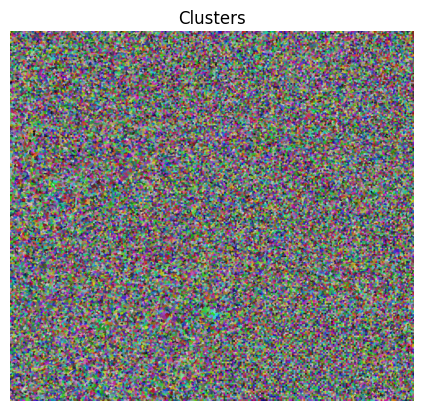

In [10]:
# Create a color map that assigns a unique color to each label
colors = np.random.randint(0, 255, size=(np.max(labels) + 1, 3))/255

# Convert the label image to a colored image using the color map
colored_labels = label2rgb(labels, image, colors=colors, alpha = 0.8)

# Display the colored image
import matplotlib.pyplot as plt
plt.imshow(colored_labels)
plt.title("Clusters")
plt.axis('off')
plt.show()

Now let's display the original image, segmented image and the segments.

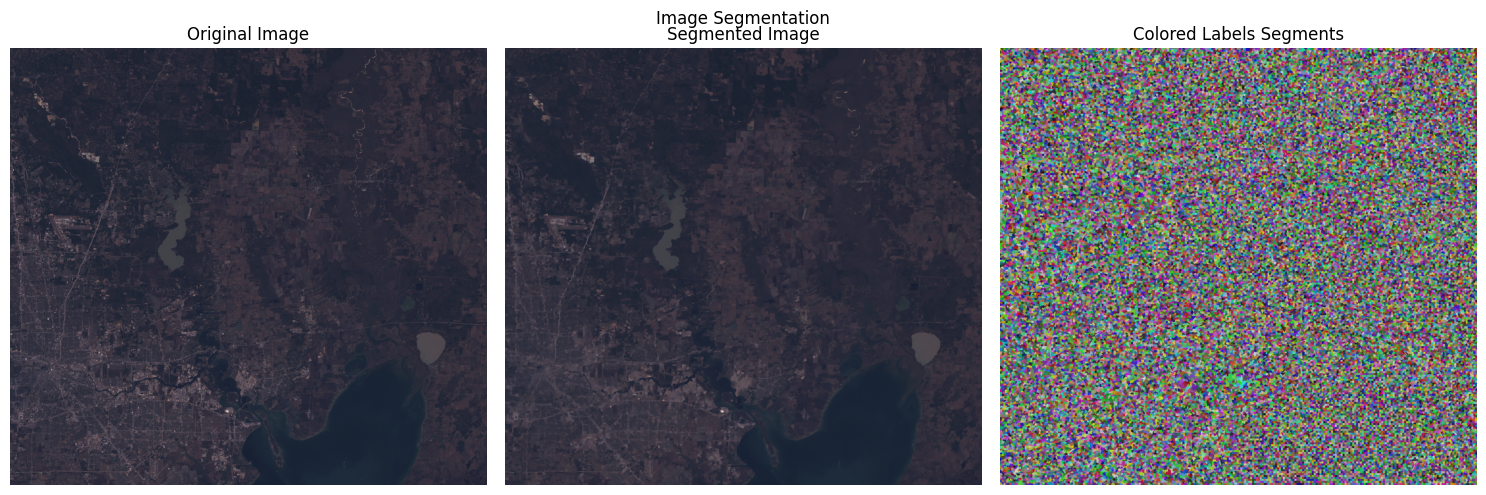

In [11]:
# Display the original image, the segmented image with median RGB values, and the colored labels side-by-side
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle('Image Segmentation')

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].set_axis_off()

axes[1].imshow(segmented_image)
axes[1].set_title('Segmented Image')
axes[1].set_axis_off()

axes[2].imshow(colored_labels)
axes[2].set_title('Colored Labels Segments')
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

And now let's zoom on a smaller region of the image

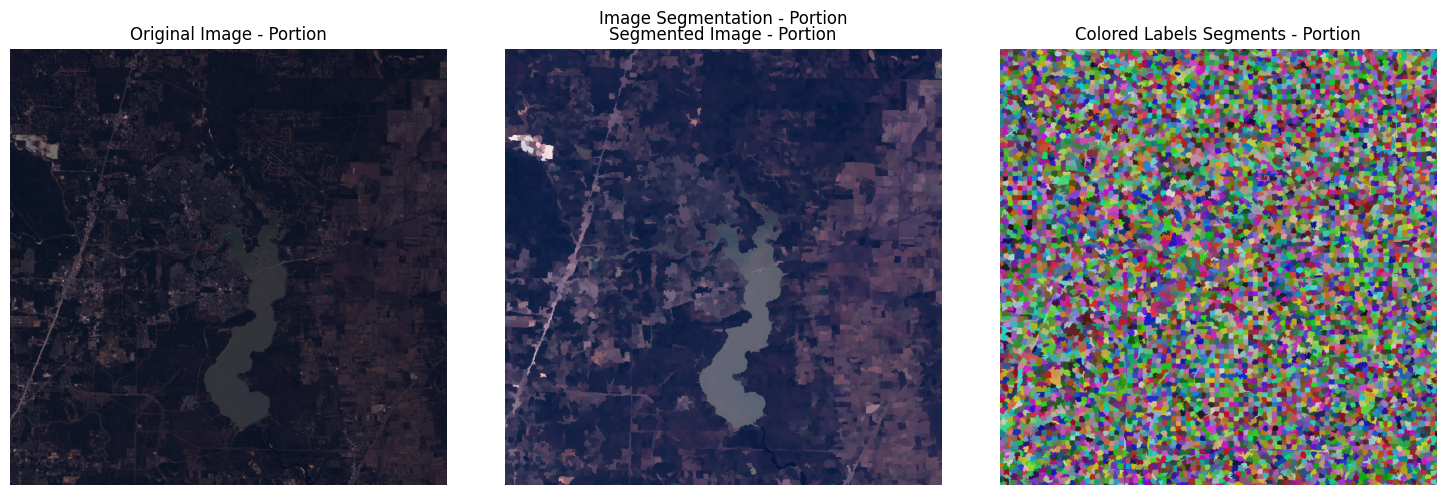

In [12]:
# Display a portion of the original image, the segmented image with median RGB values, and the colored labels side-by-side

sub1, width = 400, 1000
sub2 = sub1 + width
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle('Image Segmentation - Portion')

# Here we are rescaling the image intensity for better visualization
axes[0].imshow(
    exposure.rescale_intensity(
        image[sub1:sub2, sub1:sub2,:], out_range = (0, 1)
    )
)
axes[0].set_title('Original Image - Portion')
axes[0].set_axis_off()

axes[1].imshow(
    exposure.rescale_intensity(
        segmented_image[sub1:sub2, sub1:sub2,:], out_range = (0, 1)
    )
)
axes[1].set_title('Segmented Image - Portion')
axes[1].set_axis_off()

axes[2].imshow(colored_labels[sub1:sub2, sub1:sub2,:])
axes[2].set_title('Colored Labels Segments - Portion')
axes[2].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
#positions = np.unique(labels, return_index = True)[1]
#objects = segmented_image_full.reshape((-1,6))[positions]

<a name = '2.3'></a>
## 2.3 Get Training Data
Now our data is in the structure we want. But we will need to get the training data which is a subset of our whole data. We have our sample points in a shapefile and the _Classvalue_ filed shows the ground truth class. Let's load this file.

In [ ]:
def split_train_test():
    # read shapefile to geopandas geodataframe
    gdf = gpd.read_file('trainingPoints.shp')
    # get names of land cover classes/labels
    class_names = gdf['Classname'].unique()
    # create a unique id (integer) for each land cover class/label
    class_ids = gdf['Classvalue'].unique()

    # create a pandas data frame of the labels and ids and save to csv
    #df = pd.DataFrame({'label': class_names, 'id': class_ids})
    #df.to_csv('C:/temp/naip/class_lookup.csv')

    # add a new column to geodatafame with the id for each class/label
    #gdf['id'] = gdf['label'].map(dict(zip(class_names, class_ids)))

    # split the truth data into training and test data sets and save each to a new shapefile
    gdf_train = gdf.sample(frac=0.7)  # 70% of observations assigned to training data (30% to test data)
    gdf_test = gdf.drop(gdf_train.index)
    # save training and test data to shapefiles
    gdf_train.to_file('train_point_data.shp')
    gdf_test.to_file('test_point_data.shp')
    
    print('Train/Test split completed.')

The following code reads the training data and shows us the fields of that shapefile. We will use the field that holds class values when we raterzie it.

In [13]:
#split_train_test()

# Load the training data
train_fn = 'trainingPoints.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()

# Get the layer's definition
layer_def = lyr.GetLayerDefn()

# Print the names of all the fields in the layer
for i in range(layer_def.GetFieldCount()):
    field_def = layer_def.GetFieldDefn(i)
    print(field_def.GetName())

Id
Classvalue
Classname


Now we rasterize the shapefile. We won't save it on disk, instead we will save it on memory.

In [14]:
# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', xds.RasterXSize, xds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(xds.GetGeoTransform())
target_ds.SetProjection(xds.GetProjection())

# rasterize the training points
options = ['ATTRIBUTE=Classvalue']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)
# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()

For each segment that contains the ground truth point, we need to assign it one ground truth value. To make sure each segment is assigned only one class value, we will sequentially remove the segments that already have a class from consideration. This can be achieved using __sets__.

In [16]:
# read teh ground_truth as array
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get unique values (0 is the background, or no data, value so it is not included) for each land cover type
classes = np.unique(ground_truth)[1:]

# for each class (land cover type) record the associated segment IDs
segments_per_class = {}

for klass in classes:
    segments_of_class = labels[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)

# make sure no segment ID represents more than one class
intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    class_segments -= accum
    accum |= class_segments

# Checks if there is still any common cluster between multiple sets
flag = True
for i in segments_per_class:
    for j in segments_per_class:
        commons = segments_per_class[i].intersection(segments_per_class[j])
        if i != j and len(segments_per_class[i].intersection(segments_per_class[j])) > 0:
            flag = not flag
            print(f"Common cluster found between flass {i} and class {j}")
            print(f"Common clusters: {str(commons)}")
if flag:
    print("OK. All sets are disjoint.")

OK. All sets are disjoint.


Let's see how many cluster are in each class.

In [17]:
for k,v in segments_per_class.items():
    print(f"clss{k} has {len(v)} objects.")

clss1 has 275 objects.
clss2 has 62 objects.
clss3 has 188 objects.
clss4 has 62 objects.
clss5 has 251 objects.
clss6 has 194 objects.


For the final data cleaning step, we will obtain the values for mean and standard deviation for each cluster in our traing data for all the bands. We will store it in an array called __trainX__. We will store the corresponding class labels in an array called __trainY__.

In [18]:
# Create a trainX array where we can put the the X values for each of the training segments
# Creat a trainY array where we can put the corresponding Y class

trainX = np.zeros((sum([len(np.array(list(segments_per_class[i]))) for i in segments_per_class]), stats_array.shape[-1]))
trainY = np.zeros(trainX.shape[0])
counter = 0
for i in segments_per_class:  
    indices = np.array(list(segments_per_class[i]))
    selected_objects = stats_array[indices,:]
    trainX[counter:counter + len(indices), :] = selected_objects
    trainY[counter:counter + len(indices)] = i
    counter += len(indices)

condition = np.unique(trainX[:, -1], return_counts = True)[1].tolist() == [len(segments_per_class[i]) for i in segments_per_class], 
message = 'Something went wrong'
assert condition, message

<a name = "2.4"></a>
## 2.4 Building and Training the Model
Now that our data is cleaned, we can build a model for land use classification. With this cleaned data we can use any supervised classification model but for simplicity we will use a random forest model and use sklearn for that.

The number of estimator and maximum depth are __hyperparameters__ which control how many decision trees we train and how many recursive partions each tree will have. For a bigger problem, different tuning techniques are used to find a suitable value of these hyperparameters. Here we will use some values that generally work well.

In [19]:
# Convert classes from float to int
trainY = trainY.astype(int)

# Define the model
model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)

# Train the model
model.fit(trainX, trainY)


RandomForestClassifier(max_depth=12, n_estimators=300, random_state=42)

Let's use the trained model to make prediction on training data and get it's training accuracy.

In [20]:
# Make prediction on training data
ypred = model.predict(trainX)

# Find the training accuracy
np.mean(trainY == ypred)

0.9864341085271318

We can see our model achieved 97% training accuracy. This number by itself can not tell if our model is doing well or not. For this we will need some validation data and a baseline accuracy. We will explore this on future lessons.

<a name = "2.5"></a>
## 2.5 Predicting Using the Model
Now we have trained our model, let's use this model to make prediction. The prediction results are the classes for each clusters. Then we will change the pixel value for each cluster to it's corresponding class. This will take a minute or so.

In [22]:
# Make predictions
ypred2 = model.predict(stats_array)

# Assign predicted class to each cluster
predicted = labels.copy()

init_time = time.time()

for i in range(1, np.max(labels)+1):
    predicted[labels == i] = ypred2[i-1]
    
print(f'Class assignment completed in { (time.time() - init_time):.2f} seconds.')
pd.DataFrame({i:j for i, j in zip(("Classvalue", "Counts"), np.unique(predicted, return_counts = 1))})

Classvalue   Counts
0           1  2244443
1           2    29265
2           3  1188017
3           4    20926
4           5  1796362
5           6  1533261

<a name = "2.6"></a>
## 2.6 Visualize the Predicted Classes

In [23]:
cmap=ListedColormap(['#2023ee', '#ededed', '#4caf50','#8bcd8d', 'yellow', '#ff3f14'])

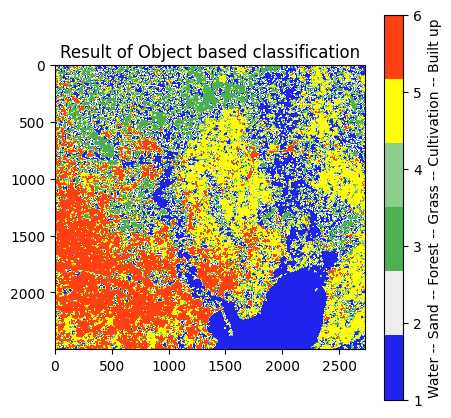

In [26]:
plt.figure(figsize = (5,5))
plt.imshow(predicted, cmap = cmap)
plt.colorbar(label = ' -- '.join(['Water', 'Sand', 'Forest', 'Grass', 'Cultivation', 'Built up' ]))
plt.title('Result of Object based classification', fontsize = 12)
plt.show()

It seems we can provide more trainig data for improving the accuracy of classification. But for now, let's show all the images side by side for better comparision.

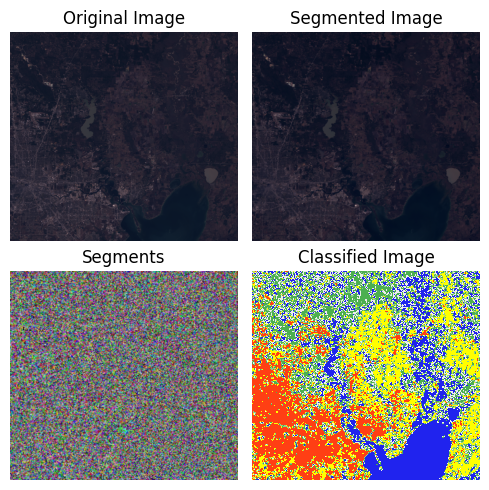

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axes[0, 0].imshow(
    exposure.rescale_intensity(
        image, out_range = (0, 1)
    )
)

axes[0, 0].axis('off')
axes[0, 0].set_title('Original Image', fontsize = 12)

axes[0 ,1].imshow(
    exposure.rescale_intensity(
        segmented_image, out_range = (0, 1)
    )
)
    
axes[0, 1].axis('off')
axes[0, 1].set_title('Segmented Image', fontsize = 12)

axes[1, 0].imshow(colored_labels)
axes[1, 0].axis('off')
axes[1, 0].set_title('Segments', fontsize = 12)

axes[1, 1].imshow(predicted, cmap = cmap)
axes[1, 1].axis('off')
axes[1, 1].set_title('Classified Image', fontsize = 12)

fig.tight_layout()

<a name = "2.7"></a>
## 2.7 Save the Prediction as Raster
We can use gdal to write the prediction as a raster. First we will create a _geotiff_ dataset, take its first band and write the prediction to it. Then set the coordinate reference system and geotransform which will  be the same as that of inpput _xds_. Finally, we need to call FlushCache method so that changes will be written on disk and that can be properly opened in other software.

In [ ]:
driver_gtiff = gdal.GetDriverByName('GTiff')

ds_create = driver_gtiff.Create('Objpredicted.tif', xsize=predicted.shape[1], ysize=predicted.shape[0], bands=1)
ds_create.GetRasterBand(1).WriteArray(predicted)

ds_create.SetProjection(xds.GetProjection())
ds_create.SetGeoTransform(xds.GetGeoTransform())
ds_create.GetRasterBand(1).FlushCache()
ds_create.FlushCache()
print(f"file written at {str(os.path.join(os.getcwd(), 'objpredicted.tif'))}")

__Congratulations!__ Now you know how to perform object based classification on satellite images. Good luck on your learning journey.